In [1]:
import numpy as np
from lqfn.numerical import utils
from lqfn.quantum_systems import NonRelativisticSingleParticle1D
from lqfn.plotting import plot_delta_E

In [2]:
T = 10

In [3]:
eps=1.4
N_copies = 10

In [4]:
def compute_G(x,n):
    N = x.shape[0]
    g = 0
    for j in range(0,N):        
        g = g + x[j]*x[(j+n)%N]
    return g/N

Consider the potential:
$$V(x) = \frac{1}{2} m \omega_0^2 x^2 (1+cm\omega_0 x^2)$$

Here we use $m=1$, $\omega_0 = 1$ and $c = 2$

In [5]:
m = 1
omega_0 = 1
c = 2
N1 = 20
N2 = 40

In [6]:
a1 = T/N1
a2 = T/N2

---
---

In [17]:
def V(x):
    return 1/2*m*omega_0**2*x**2*(1+c*m*omega_0*x**2)


def S_per_timeslice(j, x, a):
    N = x.shape[0]
    jpp = (j+2)%N
    jp = (j+1)%N
    jm = (j-1+N)%N
    jmm = (j-2+N)%N
    Sj = -0.5*x[j]*(2*x[jp] - 2*x[j] + 2*x[jm] - (2*x[jpp] - 8*x[jp] + 6*x[j] - 8*x[jm] + 2*x[jmm])/12)/a + a*V(x[j])
    return Sj

In [18]:
an_osc_imp1 = NonRelativisticSingleParticle1D(T=T, N=N1, V=V, S_per_timeslice=S_per_timeslice)
an_osc_imp2 = NonRelativisticSingleParticle1D(T=T, N=N2, V=V, S_per_timeslice=S_per_timeslice)

In [19]:
delta_E_exact_imp1 = an_osc_imp1.get_delta_E_schrodinger()
delta_E_exact_imp2 = an_osc_imp2.get_delta_E_schrodinger()
print(fr'Delta E for new anharmonic potential with a={a1}: {delta_E_exact_imp1}')
print(fr'Delta E for new anharmonic potential with a={a2}: {delta_E_exact_imp2}')

Computing...
Took 0.1549980640411377
Computing...
Took 0.16499972343444824
Delta E for new anharmonic potential with a=0.5: 0.9670716955559859
Delta E for new anharmonic potential with a=0.25: 0.4835358477779932


In [20]:
delta_E_avg_imp1, delta_E_err_imp1 = an_osc_imp1.compute_delta_E_pimc(functional=compute_G,
                                                                      N_cf=10000,
                                                                      N_cor=20,
                                                                      eps=eps,
                                                                      N_copies=N_copies,
                                                                      N_points=8)

In [21]:
delta_E_avg_imp2, delta_E_err_imp2 = an_osc_imp2.compute_delta_E_pimc(functional=compute_G,
                                                                      N_cf=10000,
                                                                      N_cor=40,
                                                                      eps=eps,
                                                                      N_copies=N_copies,
                                                                      N_points=8)

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


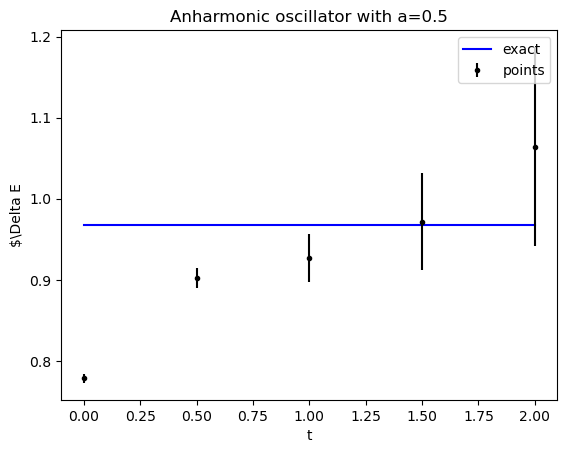

In [22]:
fig = plot_delta_E(delta_E_avg_imp1, delta_E_err_imp1,
                   exact=delta_E_exact_imp1, 
                   a=a1,
                   title=f"Anharmonic oscillator with a={a1}",
                   n=5)
fig.show()

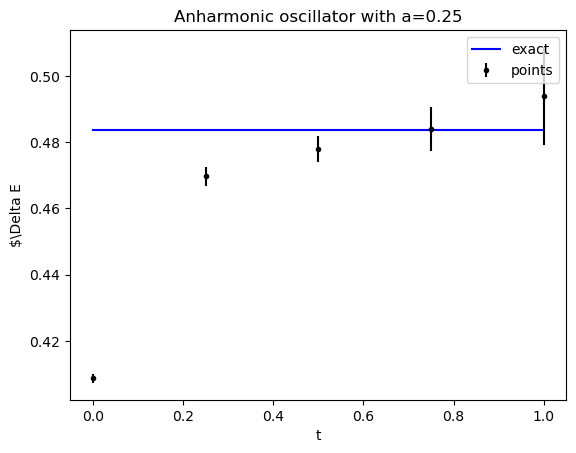

In [23]:
fig = plot_delta_E(delta_E_avg_imp2, delta_E_err_imp2,
                   exact=delta_E_exact_imp2,
                   a=a2,
                   title=f"Anharmonic oscillator with a={a2}",
                   n=5)
fig.show()

---
---

After change of variables in the path integral, the improved action looks like eq. (69) on the paper.

And then we do the path integration using the latter.

In [9]:
def V_corr(x, a, z=0):
    return 1/2*m*omega_0**2*x**2*(1+z*a+c*m*omega_0*x**2) + 1/24*a**2*m*omega_0**4*(x+2*c*m*omega_0*x**3)**2 - a*(c*m*omega_0**3*x**2/4) + 1/2*a**3*(c*m*omega_0**3*x**2/4)**2

# the following function prepares and returns S_per_timeslice with the shift correction, given a value of z
# so, if we need to create the action function with a certain value of z, we have S=factory_S_by_renormalization(z)
# and S will be the usual S_per_timeslice to be passed as a parameter to the constructor of NonRelativisticSingleParticle1D
def factory_S_by_renormalization(z=0):
    def S_per_timeslice_corr(j, x, a):
        N = x.shape[0]
        jp = (j+1)%N # next site
        jm = (j-1+N)%N # previous site
        return x[j]*(x[j]-x[jp]-x[jm])/a + a*V_corr(x[j], a, z)
    return S_per_timeslice_corr

In [10]:
an_osc_corr1 = NonRelativisticSingleParticle1D(T=T,
                                               N=N1,
                                               V=lambda x: V_corr(x, a1),
                                               S_per_timeslice=factory_S_by_renormalization(z=0))

an_osc_corr2 = NonRelativisticSingleParticle1D(T=T,
                                               N=N2,
                                               V=lambda x: V_corr(x, a2),
                                               S_per_timeslice=factory_S_by_renormalization(z=0))

---

In [11]:
delta_E_exact_corr1 = an_osc_corr1.get_delta_E_schrodinger()
delta_E_exact_corr2 = an_osc_corr2.get_delta_E_schrodinger()
print(fr'Delta E for new anharmonic potential with a={a1}: {delta_E_exact_corr1}')
print(fr'Delta E for new anharmonic potential with a={a2}: {delta_E_exact_corr2}')

Computing...
Took 0.17208266258239746
Computing...
Took 0.20700359344482422
Delta E for new anharmonic potential with a=0.5: 0.9988388927137235
Delta E for new anharmonic potential with a=0.25: 0.481790650206428


In [27]:
delta_E_avg_corr1, delta_E_err_corr1 = an_osc_corr1.compute_delta_E_pimc(functional=compute_G,
                                                                         N_cf=10000,
                                                                         N_cor=50,
                                                                         eps=eps,
                                                                         N_copies=N_copies,
                                                                         N_points=8)

In [28]:
delta_E_avg_corr2, delta_E_err_corr2 = an_osc_corr2.compute_delta_E_pimc(functional=compute_G,
                                                                         N_cf=10000,
                                                                         N_cor=80,
                                                                         eps=eps,
                                                                         N_copies=N_copies,
                                                                         N_points=8)

In [29]:
import lqfn.storage as st
data = (delta_E_avg_corr1, delta_E_err_corr1, delta_E_avg_corr2, delta_E_err_corr2)
st.save(data, 'anharmonic_oscillator_corrected')

In [7]:
import lqfn.storage as st
delta_E_avg_corr1, delta_E_err_corr1, delta_E_avg_corr2, delta_E_err_corr2 = st.load('anharmonic_oscillator_corrected')

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


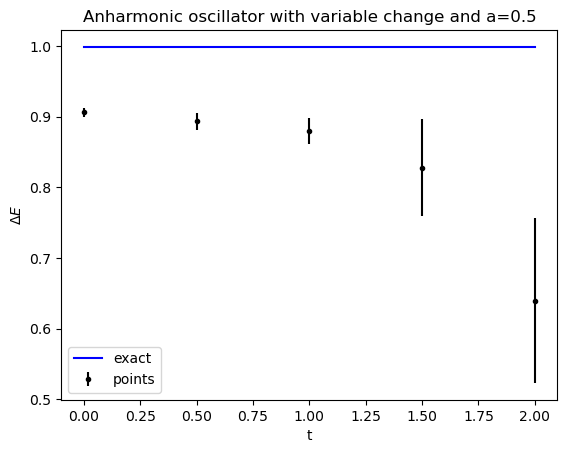

In [12]:
fig = plot_delta_E(delta_E_avg_corr1, delta_E_err_corr1,
                   exact=delta_E_exact_corr1,
                   a=a1,
                   title=f"Anharmonic oscillator with variable change and a={a1}",
                   n=5)
fig.show()

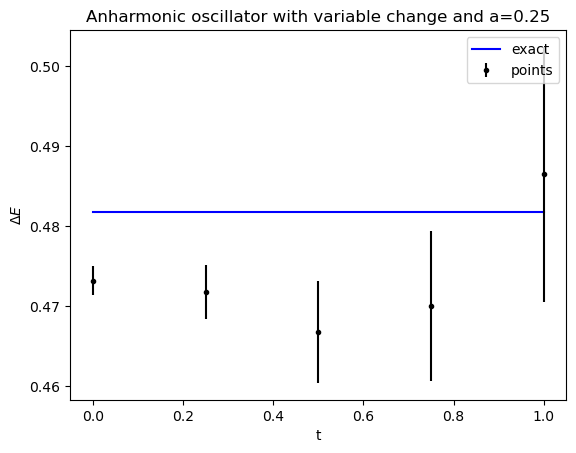

In [13]:
fig = plot_delta_E(delta_E_avg_corr2, delta_E_err_corr2,
                   exact=delta_E_exact_corr2,
                   a=a2,
                   title=f"Anharmonic oscillator with variable change and a={a2}",
                   n=5)
fig.show()

---
---

Estimate $\Delta E$ from the path integration results

In [14]:
# Choose how many points to use to estimate \Delta E
N_selected_points = 4

In [17]:
delta_E_computed_avg1, delta_E_computed_err1 = utils.get_weighted_avg_and_err(data=delta_E_avg_corr1, errs=delta_E_err_corr1, N_points=N_selected_points)
delta_E_computed_avg2, delta_E_computed_err2 = utils.get_weighted_avg_and_err(data=delta_E_avg_corr2, errs=delta_E_err_corr2, N_points=N_selected_points)

Compute the discrepancy between the obtained value and the expected value

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


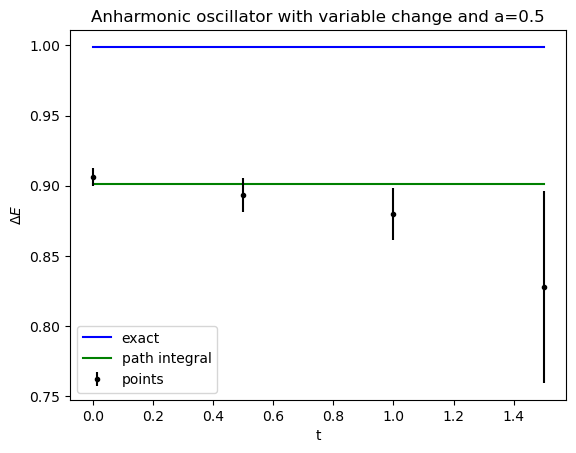

In [18]:
fig = plot_delta_E(delta_E_avg_corr1, delta_E_err_corr1,
                   exact=delta_E_exact_corr1,
                   a=a1,
                   title=f"Anharmonic oscillator with variable change and a={a1}",
                   n=N_selected_points,
                   fit=delta_E_computed_avg1)
fig.show()

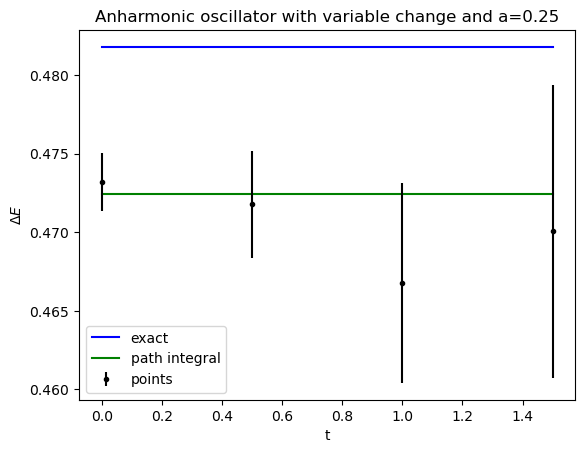

In [19]:
fig = plot_delta_E(delta_E_avg_corr2, delta_E_err_corr2,
                   exact=delta_E_exact_corr2,
                   a=a1,
                   title=f"Anharmonic oscillator with variable change and a={a2}",
                   n=N_selected_points,
                   fit=delta_E_computed_avg2)
fig.show()

In [20]:
discrepancy1 = np.abs(delta_E_exact_corr1 - delta_E_computed_avg1)/a1
discrepancy2 = np.abs(delta_E_exact_corr2 - delta_E_computed_avg2)/a2

print(f"a={a1} -> discrepancy={discrepancy1}")
print(f"a={a2} -> discrepancy={discrepancy2}")

a=0.5 -> discrepancy=0.19521154124937823
a=0.25 -> discrepancy=0.037376256165426947


---